Este dataset se trata de una empresa que quiere resolver el problema de la fuga de clientes, entender cuando estan por irse y que hacer para retenerlos. 

Luego de cargar el dataset, vimos que casi no habia problema con los datos, solo habia que eliminar unos pocos valores nulos.

Luego verificamos cuantos clientes se fueron y cuantos se quedaron.

Para investigar un poco decidi dividir el dataset en dos, por un lado los que abandonaron el servicio y por otro    los que se quedaron, con el fin de buscar patrones en cada uno haciendo algunos analisis en espejo en principio con las variables numericas.

Luego hice un analisis del resto de las variables.
Ahi notamos que algunas variables como el sexo por ejemplo no tenian ningun tipo de peso, pero otras como el servicio de internet (principalmente la fibra optica) tenian una diferencia abismal.

Despues hice un poco de enfasis en la fibra optica. Busque entender que otra variable podia afectar mas que nada al hecho de quedarse, osea a los que tenian fibra optica pero no formaban parte del grupo de fuga.
Logramos entender que el hecho de tener debito o credito automatico ayudaba a no irse, asi como tambien tener contratos anuales y no mensuales.







In [1]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:


path = kagglehub.dataset_download("blastchar/telco-customer-churn")
file_path = os.path.join(path, 'WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = pd.read_csv(file_path)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print("--- ANÁLISIS DE VALORES FALTANTES ---")
print(df.isnull().sum())
print("-" * 30)

df.dropna(inplace=True)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

df_clean = df.copy()

print(f"Dataset cargado y limpio: {df_clean.shape[0]} filas y {df_clean.shape[1]} columnas.")
df_clean.head()

--- ANÁLISIS DE VALORES FALTANTES ---
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
------------------------------
Dataset cargado y limpio: 7032 filas y 20 columnas.


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [3]:
resumen_churn = df_clean['Churn'].value_counts(normalize=True) * 100

print("--- DISTRIBUCIÓN DE LA VARIABLE OBJETIVO ---")
print(f"Se quedan (No): {resumen_churn[0]:.2f}%")
print(f"Se fugan (Yes): {resumen_churn[1]:.2f}%")   

--- DISTRIBUCIÓN DE LA VARIABLE OBJETIVO ---
Se quedan (No): 73.42%
Se fugan (Yes): 26.58%


In [4]:
clientes_perdidos = df_clean[df_clean['Churn'] == 1].copy()

print(f"Número de clientes que se fueron: {len(clientes_perdidos)}")

print("\nResumen estadístico de los que se van:")
print(clientes_perdidos[['tenure', 'MonthlyCharges', 'TotalCharges']].describe())

Número de clientes que se fueron: 1869

Resumen estadístico de los que se van:
            tenure  MonthlyCharges  TotalCharges
count  1869.000000     1869.000000   1869.000000
mean     17.979133       74.441332   1531.796094
std      19.531123       24.666053   1890.822994
min       1.000000       18.850000     18.850000
25%       2.000000       56.150000    134.500000
50%      10.000000       79.650000    703.550000
75%      29.000000       94.200000   2331.300000
max      72.000000      118.350000   8684.800000


In [5]:
clientes_leales = df_clean[df_clean['Churn'] == 0].copy()

print(f"Número de clientes que se quedaron: {len(clientes_leales)}")

print("\nResumen estadístico de los que se quedan:")
print(clientes_leales[['tenure', 'MonthlyCharges', 'TotalCharges']].describe())

Número de clientes que se quedaron: 5163

Resumen estadístico de los que se quedan:
           tenure  MonthlyCharges  TotalCharges
count  5163.00000     5163.000000   5163.000000
mean     37.65001       61.307408   2555.344141
std      24.07694       31.094557   2329.456984
min       1.00000       18.250000     18.800000
25%      15.00000       25.100000    577.825000
50%      38.00000       64.450000   1683.600000
75%      61.00000       88.475000   4264.125000
max      72.00000      118.750000   8672.450000


In [6]:
columnas_interes = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 
    'PhoneService', 'MultipleLines', 'InternetService', 
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
    'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

for col in columnas_interes:
    print(f"=== COMPARACIÓN DE: {col} ===")
    
    print(f"Fuga (Churn=1) %:")
    print(clientes_perdidos[col].value_counts(normalize=True).mul(100).round(1))
    
    print(f"\nLeales (Churn=0) %:")
    print(clientes_leales[col].value_counts(normalize=True).mul(100).round(1))
    
    print("-" * 40)

=== COMPARACIÓN DE: gender ===
Fuga (Churn=1) %:
gender
Female    50.2
Male      49.8
Name: proportion, dtype: float64

Leales (Churn=0) %:
gender
Male      50.7
Female    49.3
Name: proportion, dtype: float64
----------------------------------------
=== COMPARACIÓN DE: SeniorCitizen ===
Fuga (Churn=1) %:
SeniorCitizen
0    74.5
1    25.5
Name: proportion, dtype: float64

Leales (Churn=0) %:
SeniorCitizen
0    87.1
1    12.9
Name: proportion, dtype: float64
----------------------------------------
=== COMPARACIÓN DE: Partner ===
Fuga (Churn=1) %:
Partner
No     64.2
Yes    35.8
Name: proportion, dtype: float64

Leales (Churn=0) %:
Partner
Yes    52.8
No     47.2
Name: proportion, dtype: float64
----------------------------------------
=== COMPARACIÓN DE: Dependents ===
Fuga (Churn=1) %:
Dependents
No     82.6
Yes    17.4
Name: proportion, dtype: float64

Leales (Churn=0) %:
Dependents
No     65.7
Yes    34.3
Name: proportion, dtype: float64
----------------------------------------
=== 

In [7]:

solo_fibra = df_clean[df_clean['InternetService'] == 'Fiber optic'].copy()

fibra_se_van = solo_fibra[solo_fibra['Churn'] == 1]
fibra_se_quedan = solo_fibra[solo_fibra['Churn'] == 0]

print(f"Total clientes Fibra: {len(solo_fibra)}")
print(f"De los cuales: {len(fibra_se_van)} se fueron y {len(fibra_se_quedan)} se quedaron.\n")

variables_a_comparar = ['Contract', 'OnlineSecurity', 'TechSupport', 'PaymentMethod', 'SeniorCitizen']

for col in variables_a_comparar:
    print(f"=== FIBRA ÓPTICA: Comparando {col} ===")
    
    print(f"Los que se FUERON (Churn=1) %:")
    print(fibra_se_van[col].value_counts(normalize=True).mul(100).round(1))
    
    print(f"\nLos que se QUEDARON (Churn=0) %:")
    print(fibra_se_quedan[col].value_counts(normalize=True).mul(100).round(1))
    
    print("-" * 45)

Total clientes Fibra: 3096
De los cuales: 1297 se fueron y 1799 se quedaron.

=== FIBRA ÓPTICA: Comparando Contract ===
Los que se FUERON (Churn=1) %:
Contract
Month-to-month    89.6
One year           8.0
Two year           2.4
Name: proportion, dtype: float64

Los que se QUEDARON (Churn=0) %:
Contract
Month-to-month    53.7
One year          24.2
Two year          22.1
Name: proportion, dtype: float64
---------------------------------------------
=== FIBRA ÓPTICA: Comparando OnlineSecurity ===
Los que se FUERON (Churn=1) %:
OnlineSecurity
No     85.9
Yes    14.1
Name: proportion, dtype: float64

Los que se QUEDARON (Churn=0) %:
OnlineSecurity
No     63.5
Yes    36.5
Name: proportion, dtype: float64
---------------------------------------------
=== FIBRA ÓPTICA: Comparando TechSupport ===
Los que se FUERON (Churn=1) %:
TechSupport
No     84.9
Yes    15.1
Name: proportion, dtype: float64

Los que se QUEDARON (Churn=0) %:
TechSupport
No     62.8
Yes    37.2
Name: proportion, dtype: floa

In [8]:
filtro_especifico = (
    (df_clean['Churn'] == 0) & 
    (df_clean['InternetService'] == 'Fiber optic') &
    (df_clean['Contract'] == 'Month-to-month') &
    (df_clean['PaymentMethod'] == 'Electronic check') &
    (df_clean['OnlineSecurity'] == 'Yes') &
    (df_clean['TechSupport'] == 'Yes')
)

los_22_leales = df_clean[filtro_especifico]

print("--- LOS 22 CLIENTES 'MILAGRO' ---")
print(los_22_leales[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MonthlyCharges']].to_string())

--- LOS 22 CLIENTES 'MILAGRO' ---
      gender  SeniorCitizen Partner Dependents  tenure  MonthlyCharges
14      Male              0      No         No      25          105.50
195   Female              0     Yes         No      20           96.55
311   Female              0      No         No      22           89.05
440   Female              0     Yes        Yes      16          112.95
890     Male              0     Yes        Yes      31           89.30
1067    Male              0     Yes         No      24           89.25
1261  Female              0     Yes         No       2           80.15
1398  Female              0      No         No      24           84.35
1668  Female              0      No         No      45          115.65
2311  Female              1     Yes        Yes      48          104.50
2959    Male              0     Yes        Yes      27          100.75
3742  Female              0      No         No      41          106.50
4401  Female              1     Yes        

In [9]:
print((df_clean["MonthlyCharges"]).describe())

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64


In [10]:
# 1. Definimos el mismo filtro estricto que usaste para los 6 sobrevivientes
filtro_critico = (
    (df_clean['InternetService'] == 'Fiber optic') &
    (df_clean['Contract'] == 'Month-to-month') &
    (df_clean['PaymentMethod'] == 'Electronic check') &
    (df_clean['OnlineSecurity'] == 'Yes') &
    (df_clean['TechSupport'] == 'Yes') &
    (df_clean['Churn'] == 1)  # <--- Aquí pedimos solo los que SE FUERON
)

# 2. Seleccionamos las columnas que quieres ver
columnas_interes = ['gender', 'Partner', 'tenure', 'MonthlyCharges', 'TotalCharges']

# 3. Creamos el resultado
los_que_se_fueron = df_clean[filtro_critico][columnas_interes]

print("CLIENTES QUE SE FUERON CON EL MISMO COMBO:")
print(los_que_se_fueron)

CLIENTES QUE SE FUERON CON EL MISMO COMBO:
      gender Partner  tenure  MonthlyCharges  TotalCharges
208   Female      No      19          106.60       1934.45
876   Female      No      15          105.10       1582.75
880     Male      No      10          110.10       1043.30
2274    Male     Yes      23           99.85       2331.30
3591  Female      No       2           86.25        181.65
4875  Female     Yes      48          117.45       5438.90
5544    Male     Yes      59          106.75       6252.90
6325  Female     Yes      17           91.85       1574.45


In [11]:
# Aplicamos el filtro exacto que pediste
filtro_segmento = (
    (df_clean['Partner'] == 'Yes') &
    (df_clean['InternetService'] == 'Fiber optic') &
    (df_clean['OnlineSecurity'] == 'Yes') &
    (df_clean['TechSupport'] == 'Yes') &
    (df_clean['PaymentMethod'] == 'Electronic check') &
    (df_clean['Contract'] == 'Month-to-month')
)

# Extraemos las columnas clave incluyendo el Churn para ver quién es quién
df_segmento_completo = df_clean[filtro_segmento][['gender', 'Partner', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']]

# Ordenamos para ver a los que se quedaron y a los que se fueron juntos
df_segmento_completo = df_segmento_completo.sort_values(by='Churn')

print(f"Total de clientes en este segmento específico: {len(df_segmento_completo)}")
print(df_segmento_completo.to_string())

Total de clientes en este segmento específico: 17
      gender Partner  tenure  MonthlyCharges  TotalCharges  Churn
195   Female     Yes      20           96.55       1901.65      0
440   Female     Yes      16          112.95       1882.55      0
890     Male     Yes      31           89.30       2823.00      0
1067    Male     Yes      24           89.25       2210.20      0
1261  Female     Yes       2           80.15        194.55      0
2311  Female     Yes      48          104.50       5068.05      0
2959    Male     Yes      27          100.75       2793.55      0
4401  Female     Yes      46          110.20       4972.10      0
5126    Male     Yes      57          103.05       5925.75      0
4447    Male     Yes      68          107.70       7320.90      0
4895  Female     Yes      44           85.15       3670.50      0
5044    Male     Yes      22          104.60       2180.55      0
6439  Female     Yes      35          106.90       3756.45      0
2274    Male     Yes      

In [12]:
# Filtro exacto sin restringir el contrato
filtro_contratos = (
    (df_clean['Partner'] == 'Yes') &
    (df_clean['InternetService'] == 'Fiber optic') &
    (df_clean['OnlineSecurity'] == 'Yes') &
    (df_clean['TechSupport'] == 'Yes') &
    (df_clean['PaymentMethod'] == 'Electronic check')
)

# Seleccionamos columnas incluyendo 'Contract'
df_contratos = df_clean[filtro_contratos][['Contract', 'tenure', 'MonthlyCharges', 'Churn']]

# Ordenamos por contrato para comparar fácil
df_contratos = df_contratos.sort_values(by=['Contract', 'Churn'])

print(f"Total de clientes encontrados: {len(df_contratos)}")
print(df_contratos.to_string())

# Resumen rápido por tipo de contrato
resumen = df_contratos.groupby('Contract')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
print("\n--- PORCENTAJE DE FUGA POR CONTRATO ---")
print(resumen)

Total de clientes encontrados: 53
            Contract  tenure  MonthlyCharges  Churn
195   Month-to-month      20           96.55      0
440   Month-to-month      16          112.95      0
890   Month-to-month      31           89.30      0
1067  Month-to-month      24           89.25      0
1261  Month-to-month       2           80.15      0
2311  Month-to-month      48          104.50      0
2959  Month-to-month      27          100.75      0
4401  Month-to-month      46          110.20      0
4447  Month-to-month      68          107.70      0
4895  Month-to-month      44           85.15      0
5044  Month-to-month      22          104.60      0
5126  Month-to-month      57          103.05      0
6439  Month-to-month      35          106.90      0
2274  Month-to-month      23           99.85      1
4875  Month-to-month      48          117.45      1
5544  Month-to-month      59          106.75      1
6325  Month-to-month      17           91.85      1
566         One year      15  

In [13]:
# %% [BLOQUE DE INTELIGENCIA Y MODELADO]

# 1. INGENIERÍA DE VARIABLES (Aquí es donde debía ir)
def clasificar_riesgo_final(row):
    if row['Contract'] == 'Two year': return 0
    elif row['Contract'] == 'One year': return 1
    elif row['InternetService'] == 'Fiber optic': return 2
    else: return 1

# Aplicamos las mejoras al dataset limpio que ya tenías
df_clean['Nivel_Retencion'] = df_clean.apply(clasificar_riesgo_final, axis=1)
df_clean['Valor_Mensual_Ratio'] = df_clean['TotalCharges'] / (df_clean['tenure'] + 1)

# 2. PREPARACIÓN (Dummies)
# Ahora df_modelo tendrá las variables de riesgo incluidas
df_modelo = pd.get_dummies(df_clean, drop_first=True)

X = df_modelo.drop('Churn', axis=1)
y = df_modelo['Churn']

# Separación de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. ENTRENAMIENTO DEL XGBOOST
modelo_xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=3, 
    random_state=42
)

modelo_xgb.fit(X_train, y_train)

# 4. PREDICCIÓN Y REPORTE
y_probs = modelo_xgb.predict_proba(X_test)[:, 1]
y_pred_final = (y_probs > 0.35).astype(int)

print("--- REPORTE FINAL DE RENDIMIENTO ---")
print(classification_report(y_test, y_pred_final))

--- REPORTE FINAL DE RENDIMIENTO ---
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      1033
           1       0.45      0.86      0.59       374

    accuracy                           0.69      1407
   macro avg       0.69      0.74      0.67      1407
weighted avg       0.80      0.69      0.70      1407



In [14]:
# 1. Creamos una copia del set de prueba para no arruinar los datos originales
X_test_detallado = X_test.copy()

# 2. Le agregamos las probabilidades que calculó el modelo
X_test_detallado['Probabilidad_Fuga'] = y_probs

# 3. Recuperamos las columnas de texto del DataFrame original (df_clean) 
# usando los índices para que coincidan perfectamente
X_test_detallado['Contrato_Real'] = df_clean.loc[X_test.index, 'Contract']
X_test_detallado['Internet_Real'] = df_clean.loc[X_test.index, 'InternetService']

# 4. Ordenamos por riesgo y mostramos el Top 10 con la "evidencia"
top_10_final = X_test_detallado.sort_values(by='Probabilidad_Fuga', ascending=False).head(10)

print("--- TOP 10 CLIENTES EN RIESGO INMINENTE (CON EVIDENCIA) ---")
# Mostramos probabilidad, tiempo en la empresa y las columnas que explican el riesgo
print(top_10_final[['Probabilidad_Fuga', 'tenure', 'Contrato_Real', 'Internet_Real']])

--- TOP 10 CLIENTES EN RIESGO INMINENTE (CON EVIDENCIA) ---
      Probabilidad_Fuga  tenure   Contrato_Real Internet_Real
5186           0.975647       1  Month-to-month           DSL
1976           0.970485       1  Month-to-month   Fiber optic
2577           0.967804       1  Month-to-month   Fiber optic
5454           0.966739       1  Month-to-month   Fiber optic
997            0.966226       4  Month-to-month   Fiber optic
1731           0.964588       1  Month-to-month   Fiber optic
1325           0.964588       1  Month-to-month   Fiber optic
6748           0.964185       1  Month-to-month   Fiber optic
6488           0.963541       1  Month-to-month   Fiber optic
4837           0.962141       1  Month-to-month   Fiber optic


In [15]:
# 1. Copiamos los datos limpios
df_repaso = df_clean.copy()



# 3. Transformamos a variables dummy para que el modelo lo entienda
# Importante: Usamos las mismas columnas que usamos para entrenar (X_train)
X_final = pd.get_dummies(df_repaso.drop('Churn', axis=1))
X_final = X_final.reindex(columns=X_train.columns, fill_value=0)

# 4. El modelo predice probabilidades sobre TODO el dataset
probs_final = modelo_xgb.predict_proba(X_final)[:, 1]
preds_final = (probs_final > 0.35).astype(int)

# 5. Marcador final
from sklearn.metrics import confusion_matrix, classification_report

tm, fm, fn, tp = confusion_matrix(df_repaso['Churn'], preds_final).ravel()

print(f"--- MARCADOR FINAL DEL PROYECTO ---")
print(f"Clientes totales analizados: {len(df_repaso)}")
print(f"Fugas reales en la empresa: {df_repaso['Churn'].sum()}")
print(f"Fugas que TU MODELO detectó: {tp}")
print(f"Efectividad (Recall): {(tp/df_repaso['Churn'].sum())*100:.2f}%")
print("-" * 35)
print(f"Falsas alarmas (Clientes que se quedan pero marcaste): {fm}")

--- MARCADOR FINAL DEL PROYECTO ---
Clientes totales analizados: 7032
Fugas reales en la empresa: 1869
Fugas que TU MODELO detectó: 1774
Efectividad (Recall): 94.92%
-----------------------------------
Falsas alarmas (Clientes que se quedan pero marcaste): 1680


In [16]:
# Calculamos los aciertos sobre los que NO se fueron (Churn = 0)
# Clientes que se quedaron y el modelo predijo correctamente que se quedaban
tn = tm # Verdaderos Negativos (True Negatives)

print(f"--- ANÁLISIS DE CLIENTES LEALES (CHURN 0) ---")
print(f"Total de clientes que se quedaron de verdad: {len(df_repaso) - df_repaso['Churn'].sum()}")
print(f"Clientes leales que el modelo predijo correctamente: {tn}")
print(f"Efectividad en detectar leales (Especificidad): {(tn / (len(df_repaso) - df_repaso['Churn'].sum())) * 100:.2f}%")
print("-" * 35)
print(f"Falsas alarmas (Leales que el modelo 'asustó' marcándolos como fuga): {fm}")

--- ANÁLISIS DE CLIENTES LEALES (CHURN 0) ---
Total de clientes que se quedaron de verdad: 5163
Clientes leales que el modelo predijo correctamente: 3483
Efectividad en detectar leales (Especificidad): 67.46%
-----------------------------------
Falsas alarmas (Leales que el modelo 'asustó' marcándolos como fuga): 1680


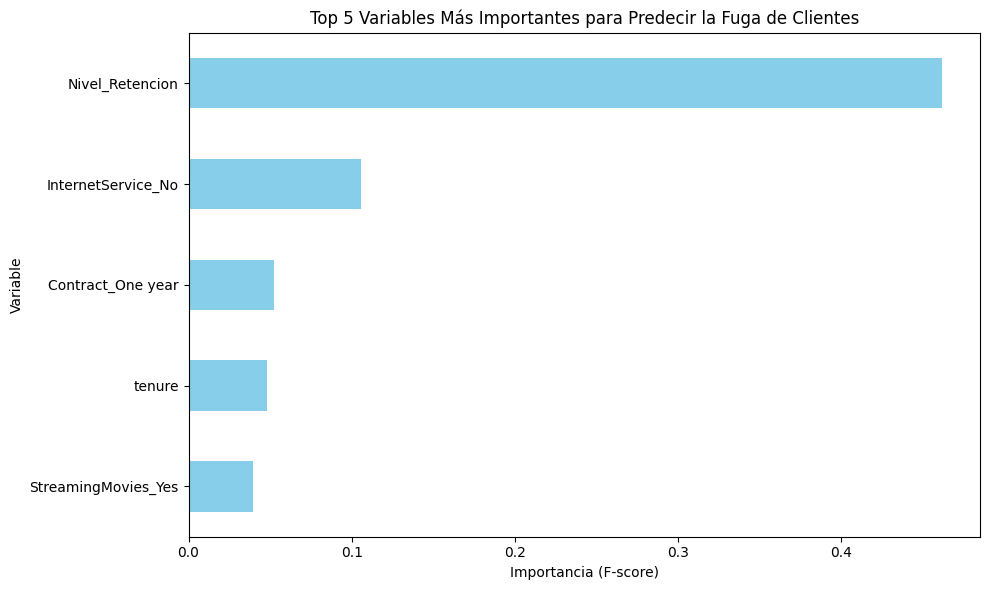


--- INTERPRETACIÓN DE LAS VARIABLES CLAVE ---
Este gráfico muestra las características que el modelo XGBoost consideró más influyentes para predecir si un cliente se fugará o no.
Podemos observar que las decisiones de la IA están fuertemente impulsadas por factores como el tipo de contrato, la duración de la estancia y el tipo de servicio de internet.
Esto refuerza la importancia de estrategias de retención enfocadas en estos aspectos.


In [17]:

# Calculamos la importancia de cada característica según el modelo XGBoost
importances = pd.Series(modelo_xgb.feature_importances_, index=X.columns)

# Seleccionamos las 5 más importantes y las ordenamos
top_5_importantes = importances.nlargest(5)

# Creamos el gráfico de barras
plt.figure(figsize=(10, 6))
top_5_importantes.plot(kind='barh', color='skyblue')
plt.title('Top 5 Variables Más Importantes para Predecir la Fuga de Clientes')
plt.xlabel('Importancia (F-score)')
plt.ylabel('Variable')
plt.gca().invert_yaxis() # Para que la variable más importante quede arriba
plt.tight_layout() # Ajusta el diseño para que no se corten las etiquetas
plt.show()

print("\n--- INTERPRETACIÓN DE LAS VARIABLES CLAVE ---")
print("Este gráfico muestra las características que el modelo XGBoost consideró más influyentes para predecir si un cliente se fugará o no.")
print("Podemos observar que las decisiones de la IA están fuertemente impulsadas por factores como el tipo de contrato, la duración de la estancia y el tipo de servicio de internet.")
print("Esto refuerza la importancia de estrategias de retención enfocadas en estos aspectos.")